In [1]:
import pickle, time, re
from collections import OrderedDict
from tabulate import tabulate

import numpy as np
from numpy.random import seed

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split

# Algorithms
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import lightgbm as lgbm

# Adversarial Robustness Toolbox
from art.estimators.classification import SklearnClassifier
from art.estimators.classification.lightgbm import LightGBMClassifier
from art.attacks.evasion import ProjectedGradientDescent, FastGradientMethod, HopSkipJump

import shap

# ignore some specific warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# fix up some numpy disply options
np.set_printoptions(suppress=True)

C:\Users\wschroeder\AppData\Roaming\Python\Python39\site-packages\art\estimators\certification\__init__.py:12: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


In [2]:
# fixate the random state for reproducability
RANDOM_STATE = 1337
seed(RANDOM_STATE)

In [3]:
# read in complete labeled data set
df = pd.read_csv('../datasets/PowerShellCorpus.ast.csv')

# split into target variable and input features
paths = df.Path
y = df.Label
X = df.drop( ['Path', 'Label'], axis=1)

# preserve the path in case we need it
X_path = df.drop( ['Label'], axis=1)
X_train_path, X_test_path, y_train, y_test = train_test_split(X_path, y, test_size=0.2, random_state=RANDOM_STATE)

# split off 20% of the data for final testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [4]:
# from BorutaShap import BorutaShap
# Feature_Selector = BorutaShap(importance_measure='shap', classification=True)
# Feature_Selector = pickle.load(open("boruta-shap.bin", "rb"))
# Feature_Selector.accepted

# the above ^ results in the following "Accepted" features:
boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']
print(f"Number of features selected from Boruta-Shap: {len(boruta_shap_accepted_features)}")
X_boruta_shap = X[boruta_shap_accepted_features]
X_train_boruta_shap = X_train[boruta_shap_accepted_features]
X_test_boruta_shap = X_test[boruta_shap_accepted_features]

# remove "Json" style named features for some of the boosted algorithms that don't like the feature names
X_boruta_shap = X_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_boruta_shap = X_train_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_boruta_shap = X_test_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Example of finding the index of a particular feature name:
# X_train_boruta_shap.columns.get_loc("AstStringMetrics_Length_Median")

Number of features selected from Boruta-Shap: 446


# Evading the Ridge Logistic Regression

In [5]:
# load the saved model
tuned_ridge = pickle.load(open("../models/tuned_ridge.bin", "rb"))

Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Pipeline from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.


In [6]:
# extract the model parameters
intercept = tuned_ridge._final_estimator.intercept_
coefs = tuned_ridge._final_estimator.coef_[0]

In [7]:
# map features to coefficients for easy sorting
feature_values = np.array(zip(boruta_shap_accepted_features, coefs))

coef_dict = {}
for coef, feat in zip(coefs, boruta_shap_accepted_features):
    coef_dict[feat] = coef

In [8]:
# get the top "Normal" and "Obfuscated" feature coefficients
sorted_by_value = OrderedDict(sorted(coef_dict.items(), key=lambda x: x[1]))

print("Top 'Normal' Features:")
print(tabulate([item for item in sorted_by_value.items()][0:20]))

print("\nTop 'Obfuscated' Features:")
print(tabulate([item for item in sorted_by_value.items()][-10:]))

Top 'Normal' Features:
--------------------------------------------------------------------  --------
AstMemberMetrics_CharacterDistribution_y_79_Percent                   -5.32852
LineByLineMetrics_CharacterDistribution__22_Percent"                  -3.62476
AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent  -3.25847
LineByLineMetrics_UpperAlphaPercent_Median                            -2.96711
LineByLineMetrics_CharacterDistribution_m_6d_Percent                  -2.92863
AstCmdletMetrics_CharacterDistribution_T_54_Percent                   -2.9064
LineByLineMetrics_Entropy_Average                                     -2.64746
AstMemberArgumentMetrics_UpperAlphaPercent_Minimum                    -2.64414
AstCmdletMetrics_CharacterDistribution_-_2d_Percent                   -2.54312
LineByLineMetrics_CharacterDistribution_|_7c_Percent                  -2.4735
AstGroupedAstTypes_CommandExpressionAst_Percent                       -2.44018
LineByLineMetrics_Density_Avera

In [9]:
# the original DBOdemo1.ps1 script AST feature set
df_demo_orig = pd.read_csv('../samples/DBOdemo1.ps1.ast.csv')

# read in the modified DBOdemo1.ps1 script AST feature set
#    Here, we've modified the script to increase the AstMemberMetrics_CharacterDistribution_y_79_Percent feature
df_demo_ridge_mod = pd.read_csv('../samples/DBOdemo1_ridge.ps1.ast.csv')

# split into target variable and input features
y_demo_orig = df_demo_orig.Label
X_demo_orig = df_demo_orig.drop( ['Path', 'Label'], axis=1)
y_demo_ridge_mod = df_demo_ridge_mod.Label
X_demo_ridge_mod = df_demo_ridge_mod.drop( ['Path', 'Label'], axis=1)

# select just the Boruta-Shap features we want
X_demo_orig_boruta_shap = X_demo_orig[boruta_shap_accepted_features]
X_demo_ridge_mod_boruta_shap = X_demo_ridge_mod[boruta_shap_accepted_features]

# remove "Json" style named features for some of the boosted algorithms that don't like the feature names
X_demo_orig_boruta_shap = X_demo_orig_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_demo_ridge_mod_boruta_shap = X_demo_ridge_mod_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print("Original AstMemberMetrics_CharacterDistribution_y_79_Percent :", X_demo_orig_boruta_shap["AstMemberMetrics_CharacterDistribution_y_79_Percent"][0])
print(f"Original Predicted label                                     : {tuned_ridge.predict(X_demo_orig_boruta_shap.values.reshape(1, -1))[0]}")

# show the effect on the prediction label
print("Modified AstMemberMetrics_CharacterDistribution_y_79_Percent :", X_demo_ridge_mod_boruta_shap["AstMemberMetrics_CharacterDistribution_y_79_Percent"][0])
print(f"Modified Predicted label                                     : {tuned_ridge.predict(X_demo_ridge_mod_boruta_shap.values.reshape(1, -1))[0]}")

Original AstMemberMetrics_CharacterDistribution_y_79_Percent : 0
Original Predicted label                                     : 1
Modified AstMemberMetrics_CharacterDistribution_y_79_Percent : 58.22222222222221
Modified Predicted label                                     : 0


**As shown above, we've successfully evaded the Ridge Logistic Regression model for obfuscation detection.**

# Evading the LightGBMClassifier

In [10]:
tuned_lgbm = pickle.load(open('../models/tuned_lgbm.bin', 'rb'))

Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.


In [11]:
# zip up the feature importances from the model for later processing
feature_imp = pd.DataFrame(sorted(zip(tuned_lgbm.feature_importances_,X_train_boruta_shap.columns)), columns=['Value','Feature'])

In [12]:
print("30 most important features for the LGBMClassifier:\n")

feature_imp = sorted(zip(tuned_lgbm.feature_importances_,X_train_boruta_shap.columns), reverse=True)

print(tabulate(feature_imp[:30], headers=["Importance", "Feature Name"]))

30 most important features for the LGBMClassifier:

  Importance  Feature Name
------------  -------------------------------------------------------------------------
         161  LineByLineMetrics_CharacterDistribution__27_Percent
          96  LineByLineMetrics_CharacterDistribution__60_Percent
          90  AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent
          78  AstGroupedAstTypes_BinaryExpressionAst_Percent
          70  LineByLineMetrics_CharacterDistribution__22_Percent
          68  AstMemberMetrics_UpperAlphaPercent_Median
          68  AstGroupedAstTypes_VariableExpressionAst_Percent
          67  LineByLineMetrics_Density_Average
          63  LineByLineMetrics_CharacterDistribution_e_65_Percent
          63  AstCmdletMetrics_CharacterDistribution_e_65_Percent
          61  AstStringMetrics_Entropy_Average
          60  LineByLineMetrics_Length_Range
          60  LineByLineMetrics_Length_Maximum
          60  AstGroupedAstTypes_ParenExpressionAst_P

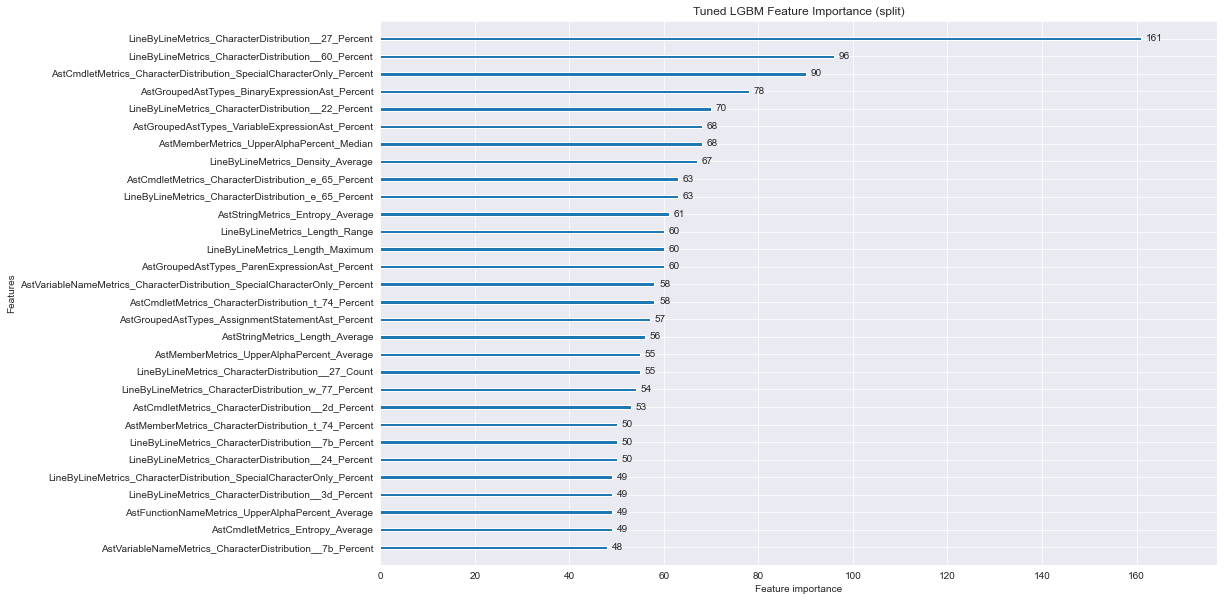

In [13]:
ax = lgbm.plot_importance(tuned_lgbm,
                          title="Tuned LGBM Feature Importance (split)",
                          importance_type='split',
                          max_num_features=30,
                          figsize=(15, 10))

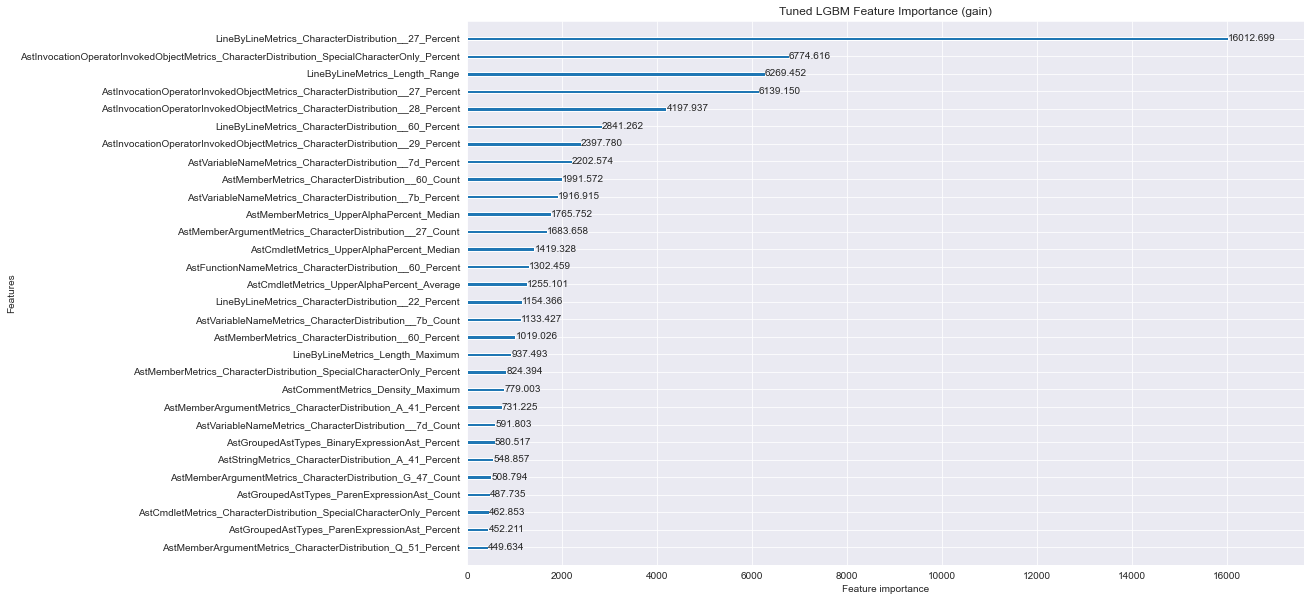

In [14]:
ax = lgbm.plot_importance(tuned_lgbm,
                          title="Tuned LGBM Feature Importance (gain)",
                          importance_type='gain',
                          max_num_features=30,
                          figsize=(15, 10))

### SHAP for LightGBMClassifier

In [15]:
t = time.time()

# create a tree-focused SHAP explainer
tree_explainer = shap.TreeExplainer(tuned_lgbm)

# calculate the SHAP values for ALL data (training and test)
shap_values = tree_explainer.shap_values(X_boruta_shap)

print(f"Shapley values calculated in : {time.time() - t}")

Shapley values calculated in : 14.823574542999268


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [16]:
# # optionally save off the raw SHAP values
# vals = np.abs(shap_values).mean(0)
# feature_importance = pd.DataFrame(list(zip(X_boruta_shap.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
# feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
# feature_importance.to_csv("lgbm_shap_values.csv")

SHAP values for the top 30 features for all data (towards the 'Obfuscated' label)


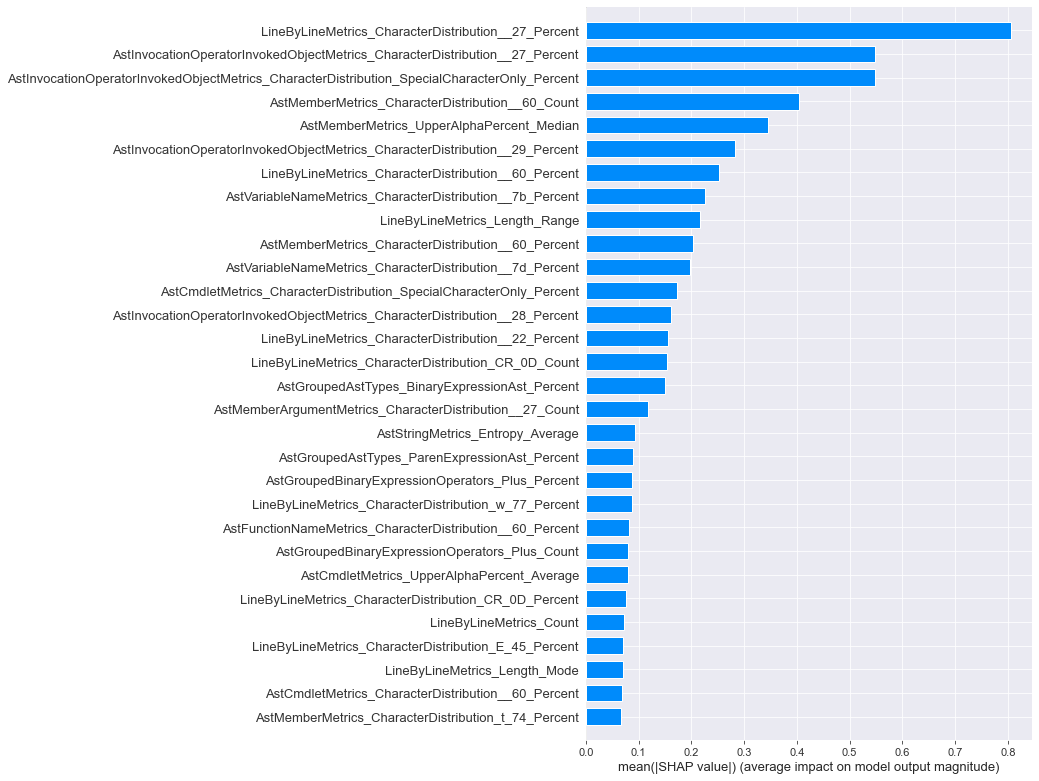

In [17]:
num_features = 30

# display the SHAP summary plot for the top X features, showing the most impactful features
print(f"SHAP values for the top {num_features} features for all data (towards the 'Obfuscated' label)")
shap.summary_plot(shap_values[1], X_boruta_shap, plot_type='bar', max_display=num_features)

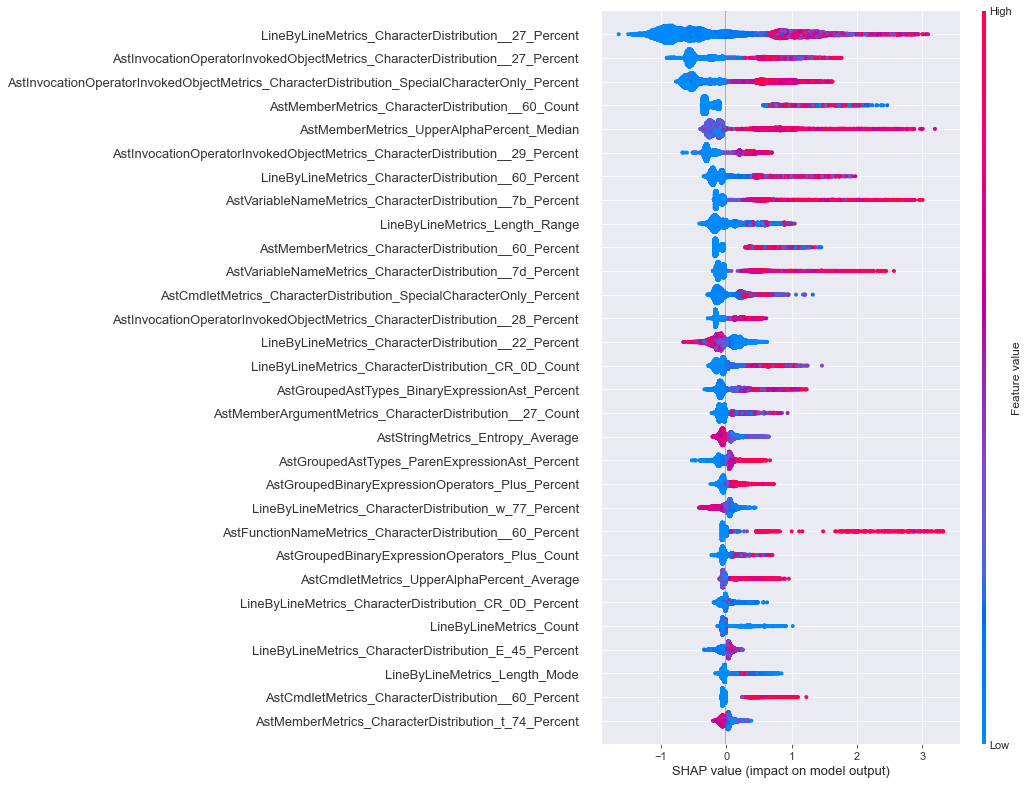

None

In [18]:
# display the SHAP summary plot for the top X features, showing the most impactful features and in which direction they incluence the decision
display(shap.summary_plot(shap_values[1], X_boruta_shap, max_display=num_features))

In [19]:
# helper to generate SHAP values for a sample and display waterfall and decision plots

def explain_shap_sample(explainer, X_input):
    shap_values = explainer.shap_values(X_input)
    
    print("SHAP waterfall plot")
    display(shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1],
                                                   shap_values[1][0,:],
                                                   feature_names = X_input.columns,
                                                   max_display = 20))
    
    print("SHAP decision plot")
    display(shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], X_input.iloc[0,:]))

SHAP waterfall plot


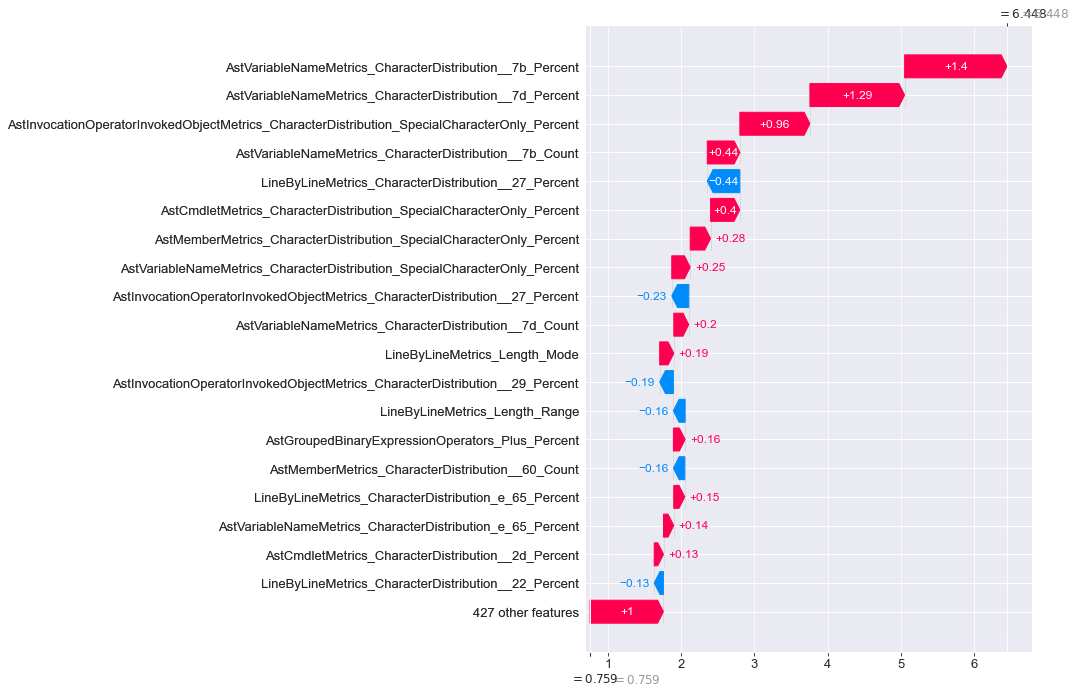

None

SHAP decision plot


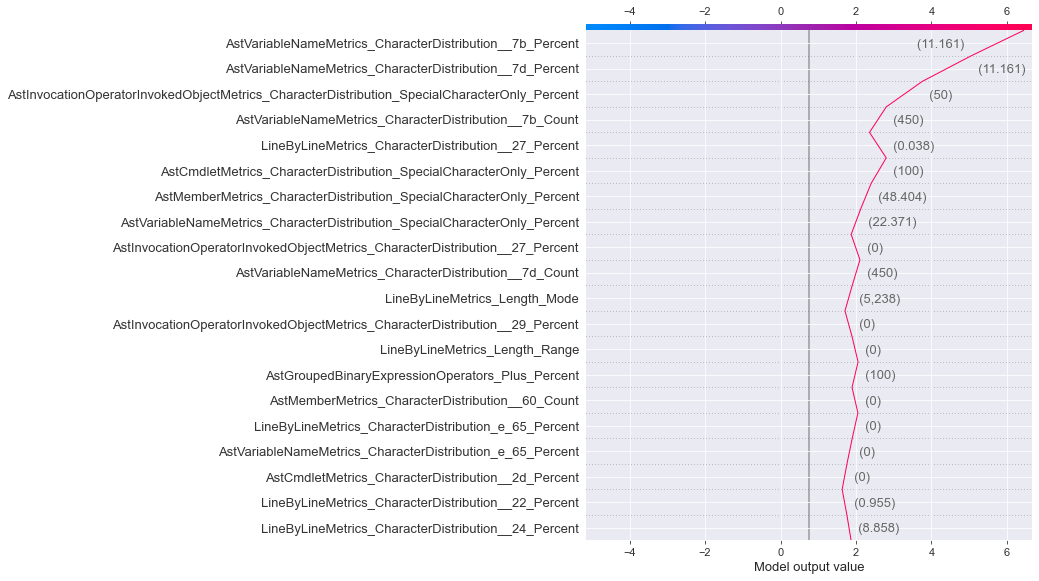

None

In [20]:
# see what the original sample looks like
explain_shap_sample(tree_explainer, X_demo_orig_boruta_shap)

Original AstVariableNameMetrics_CharacterDistribution__7b_Percent : 11.160714285714299
Modified AstVariableNameMetrics_CharacterDistribution__7b_Percent : 2.77983691623425
Original AstVariableNameMetrics_CharacterDistribution__7d_Percent : 11.160714285714299
Modified AstVariableNameMetrics_CharacterDistribution__7d_Percent : 2.77983691623425
Original LineByLineMetrics_CharacterDistribution__22_Percent : 0.9545628102329129
Modified LineByLineMetrics_CharacterDistribution__22_Percent : 3.12319259687681
Original LineByLineMetrics_CharacterDistribution__24_Percent : 8.85834287896144
Modified LineByLineMetrics_CharacterDistribution__24_Percent : 4.2246083436014805
Original LineByLineMetrics_CharacterDistribution_w_77_Percent : 0
Modified LineByLineMetrics_CharacterDistribution_w_77_Percent : 14.8615686373123
Original AstMemberMetrics_CharacterDistribution_y_79_Percent : 0
Modified AstMemberMetrics_CharacterDistribution_y_79_Percent : 98.46002621231979
Original AstInvocationOperatorInvokedOb

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


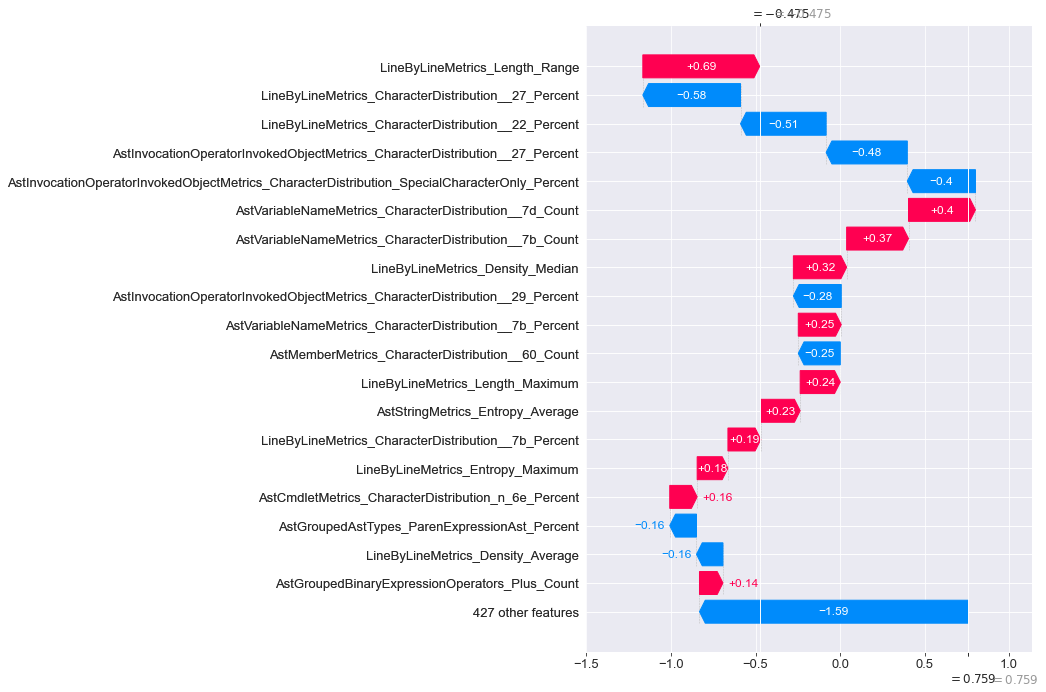

None

SHAP decision plot


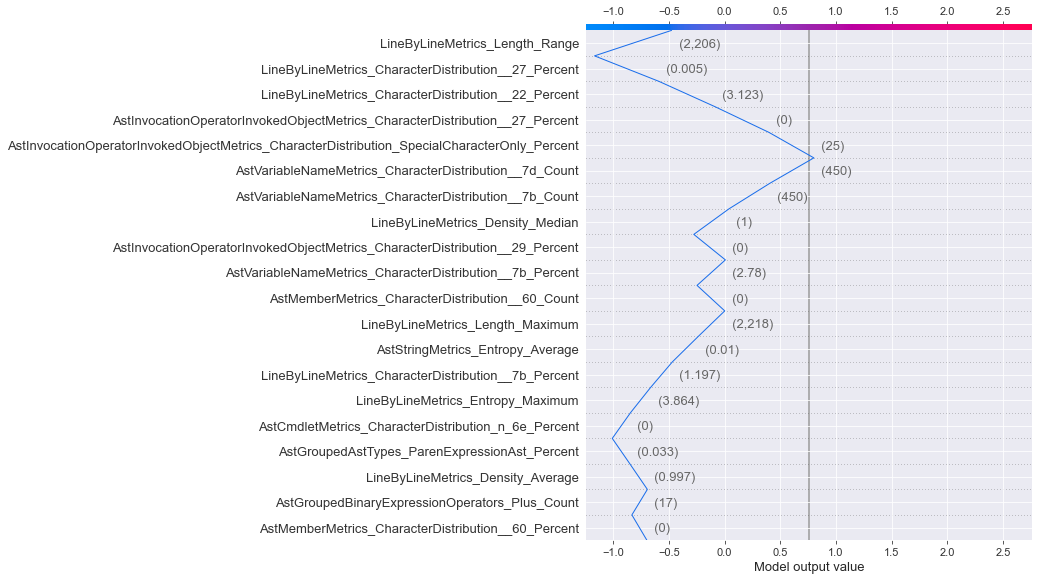

None

In [21]:
# read in the modified DBOdemo1.ps1 script
#    There were a LOT of modifications here, iteratively done at this step to
#    continually adjust features that were pushing the boundary to 'obfuscated'
df_demo_lgbm_mod = pd.read_csv('../samples/DBOdemo1_lgbm.ps1.ast.csv')

# split into target variable and input features
y_demo_lgbm_mod = df_demo_lgbm_mod.Label
X_demo_lgbm_mod = df_demo_lgbm_mod.drop( ['Path', 'Label'], axis=1)

# select just the Boruta-Shap features we want
X_demo_lgbm_mod_boruta_shap = X_demo_lgbm_mod[boruta_shap_accepted_features]

# remove "Json" style named features for some of the boosted algorithms that don't like the feature names
X_demo_lgbm_mod_boruta_shap = X_demo_lgbm_mod_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# 0x24 -> $, 0x22 -> ", 0x7b -> {, 0x7d -> }
features = ["AstVariableNameMetrics_CharacterDistribution__7b_Percent",
            "AstVariableNameMetrics_CharacterDistribution__7d_Percent",
            "LineByLineMetrics_CharacterDistribution__22_Percent",
            "LineByLineMetrics_CharacterDistribution__24_Percent",
            "LineByLineMetrics_CharacterDistribution_w_77_Percent",
            "AstMemberMetrics_CharacterDistribution_y_79_Percent",
            "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent"]

# see how much the features changed
for feature in features:
    print(f"Original {feature} :", X_demo_orig_boruta_shap[feature].iloc[0])
    print(f"Modified {feature} :", X_demo_lgbm_mod_boruta_shap[feature].iloc[0])
    
print(f"\nOriginal Predicted label : {tuned_lgbm.predict(X_demo_orig_boruta_shap.values.reshape(1, -1))[0]}")
# show the effect on the prediction label
print(f"Modified Predicted label : {tuned_lgbm.predict(X_demo_lgbm_mod_boruta_shap.values.reshape(1, -1))[0]}\n")

# show the new decision plots
explain_shap_sample(tree_explainer, X_demo_lgbm_mod_boruta_shap)

**As shown above, we've successfully evaded the LightGBM classifier model for obfuscation detection.**

# Attacking the Logistic Regression With Attack Algorithms

In [22]:
# read in the original DBOdemo1.ps1 script
df_demo_orig = pd.read_csv('../samples/DBOdemo1.ps1.ast.csv')

# split into target variable and input features
y_demo_orig = df_demo_orig.Label
X_demo_orig = df_demo_orig.drop( ['Path', 'Label'], axis=1)

# select just the Boruta-Shap features we want
X_demo_orig_boruta_shap = X_demo_orig[boruta_shap_accepted_features]

# remove "Json" style named features for some of the boosted algorithms that don't like the feature names
X_demo_orig_boruta_shap = X_demo_orig_boruta_shap.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [23]:
# AstMemberArgumentMetrics_CharacterDistribution - arguments to a method, like $sb.Append('abc')
#   https://github.com/danielbohannon/Revoke-Obfuscation/blob/master/Checks/AST_Member_Argument_Character_Distribution.cs
#   https://docs.microsoft.com/en-us/dotnet/api/system.management.automation.language.invokememberexpressionast?view=powershellsdk-7.0.0
# LineByLineMetrics_CharacterDistribution - metrics for each line, split by Environment.NewLine

features_to_modify = [
    "AstMemberArgumentMetrics_CharacterDistribution__5b_Count",
    "AstMemberArgumentMetrics_CharacterDistribution__5d_Count",
    "AstMemberArgumentMetrics_CharacterDistribution_A_41_Count",
    "AstMemberArgumentMetrics_CharacterDistribution_E_45_Count",
    "AstMemberArgumentMetrics_CharacterDistribution_F_46_Count",
    "AstMemberArgumentMetrics_CharacterDistribution_H_48_Count",
    "AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count",
    "AstCmdletMetrics_CharacterDistribution_c_63_Count",
    "AstCmdletMetrics_CharacterDistribution_e_65_Count",
    "AstCmdletMetrics_CharacterDistribution_j_6a_Count",
    "AstCmdletMetrics_CharacterDistribution_w_77_Count",
    "AstStringMetrics_CharacterDistribution_4_34_Count",
    "AstStringMetrics_CharacterDistribution_A_41_Count",
    "AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count",
    "LineByLineMetrics_CharacterDistribution_4_34_Count",
    "LineByLineMetrics_CharacterDistribution_A_41_Count"
]

mask = np.zeros(shape=X_demo_orig_boruta_shap.iloc[0].shape, dtype=bool)

indicies = []

# build the mask from the selected features
for feature in features_to_modify:
    index = X_demo_orig_boruta_shap.columns.get_loc(feature)
    indicies += [index]
    mask[index] = True

In [24]:
# load the saved model
tuned_ridge = pickle.load(open("../models/tuned_ridge.bin", "rb"))

# build the ART wrapper for the classifier
art_classifier = SklearnClassifier(model=tuned_ridge[1])

# extract the scaler from the Logistic Regression pipeline
lr_scaler = tuned_ridge[0]

# scale the demo features for this sample
X_demo_orig_boruta_shap_scaled = lr_scaler.transform(X_demo_orig_boruta_shap)

Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Pipeline from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.


## ProjectedGradientDescent - With Feature Mask

In [25]:
# L1 norm performs better than Linf or L2
attack = ProjectedGradientDescent(estimator=art_classifier, norm=1, eps=30, eps_step=0.1, max_iter=1000, targeted=False)

x_adv = attack.generate(x=X_demo_orig_boruta_shap_scaled, mask=mask)

orig_label = np.argmax(art_classifier.predict(X_demo_orig_boruta_shap_scaled)[0])
new_label = np.argmax(art_classifier.predict(x_adv)[0])

print(f"Original label : {orig_label}")
print(f"New label      : {new_label}")

print("\nOriginal feature values:")
print(np.around((X_demo_orig_boruta_shap_scaled[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values (scaled):")
print(np.around((x_adv[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values (unscaled):")
print(np.around(lr_scaler.inverse_transform((x_adv[0]).reshape(1, -1))[0][mask], 4))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Original label : 1
New label      : 0

Original feature values:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.0001 0.     0.     0.    ]]

Adv feature values (scaled):
[[2.0432 0.6312 1.0526 4.82   0.6945 1.5034 0.6989 0.7146 2.9459 2.9564
  0.6332 1.7071 4.5345 1.0946 1.1402 2.8297]]

Adv feature values (unscaled):
[  4378.5654 273558.47    19536.098    1513.487     516.0382   9778.08
    519.3072  19940.002    8955.469    8555.7705  17670.797    7360.908
 307826.38   436197.6    453955.94    12948.62  ]


## ProjectedGradientDescent - No Feature Mask

In [26]:
# L1 norm performs better than Linf or L2
attack = ProjectedGradientDescent(estimator=art_classifier, norm=1, eps=5.326, eps_step=0.01, max_iter=1000, targeted=False)
x_adv = attack.generate(x=X_demo_orig_boruta_shap_scaled)

orig_label = np.argmax(art_classifier.predict(X_demo_orig_boruta_shap_scaled)[0])
new_label = np.argmax(art_classifier.predict(x_adv)[0])

print(f"Original label : {orig_label}")
print(f"New label      : {new_label}")

print("\nOriginal feature values:")
print(np.around((X_demo_orig_boruta_shap_scaled[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values (scaled):")
print(np.around((x_adv[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values (unscaled):")
print(np.around(lr_scaler.inverse_transform((x_adv[0]).reshape(1, -1))[0][mask], 4))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Original label : 1
New label      : 0

Original feature values:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.0001 0.     0.     0.    ]]

Adv feature values (scaled):
[[0.0045 0.0014 0.0023 0.0106 0.0015 0.0033 0.0015 0.0016 0.0065 0.0065
  0.0014 0.0038 0.0101 0.0024 0.0025 0.0062]]

Adv feature values (unscaled):
[  9.6231 601.2214  42.9359   3.3263   1.1341  21.4899   1.1413  43.8239
  19.6821  18.8036  38.8362  16.1776 682.52   958.6683 997.6984  28.4582]


## FastGradientMethod - With Feature Mask

In [27]:
# L1 norm performs better than Linf or L2
attack = FastGradientMethod(estimator=art_classifier, norm=1, eps=30, eps_step=0.1, targeted=False)

x_adv = attack.generate(x=X_demo_orig_boruta_shap_scaled, mask=mask)

orig_label = np.argmax(art_classifier.predict(X_demo_orig_boruta_shap_scaled)[0])
new_label = np.argmax(art_classifier.predict(x_adv)[0])

print(f"Original label : {orig_label}")
print(f"New label      : {new_label}")

print("\nOriginal feature values:")
print(np.around((X_demo_orig_boruta_shap_scaled[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values (scaled):")
print(np.around((x_adv[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values (unscaled):")
print(np.around(lr_scaler.inverse_transform((x_adv[0]).reshape(1, -1))[0][mask], 4))

Original label : 1
New label      : 0

Original feature values:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.0001 0.     0.     0.    ]]

Adv feature values (scaled):
[[2.0202 0.6241 1.0408 4.7658 0.6867 1.4865 0.6911 0.7066 2.9128 2.9232
  0.6261 1.6879 4.4835 1.0823 1.1274 2.7979]]

Adv feature values (unscaled):
[  4329.334  270482.3     19316.463    1496.4747    510.2375   9668.145
    513.4701  19715.898    8854.822    8459.609   17472.13     7278.1807
 304365.75   431294.72   448853.03    12803.026 ]


## FastGradientMethod - No Feature Mask

In [28]:
# L1 norm performs better than Linf or L2
attack = FastGradientMethod(estimator=art_classifier, norm=1, eps=5.326, eps_step=0.01, targeted=False)

x_adv = attack.generate(x=X_demo_orig_boruta_shap_scaled)

orig_label = np.argmax(art_classifier.predict(X_demo_orig_boruta_shap_scaled)[0])
new_label = np.argmax(art_classifier.predict(x_adv)[0])

print(f"Original label : {orig_label}")
print(f"New label      : {new_label}")

print("\nOriginal feature values:")
print(np.around((X_demo_orig_boruta_shap_scaled[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values (scaled):")
print(np.around((x_adv[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values (unscaled):")
print(np.around(lr_scaler.inverse_transform((x_adv[0]).reshape(1, -1))[0][mask], 4))

Original label : 1
New label      : 0

Original feature values:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.0001 0.     0.     0.    ]]

Adv feature values (scaled):
[[0.0045 0.0014 0.0023 0.0106 0.0015 0.0033 0.0015 0.0016 0.0065 0.0065
  0.0014 0.0038 0.0101 0.0024 0.0025 0.0062]]

Adv feature values (unscaled):
[  9.6218 601.1366  42.9301   3.3259   1.134   21.4871   1.1412  43.8178
  19.6795  18.8012  38.8311  16.1755 682.428  958.536  997.5588  28.4542]


## HopSkipJump - With Feature Mask

In [29]:
# build the ART wrapper for the classifier, including the scaler this time
art_classifier = SklearnClassifier(model=tuned_ridge)

attack = HopSkipJump(classifier=art_classifier, targeted=False, verbose=False)

orig_label = np.argmax(art_classifier.predict(X_demo_orig_boruta_shap)[0])

iter_step = 30
x_adv = None
x_orig = X_demo_orig_boruta_shap.values

x_adv = attack.generate(x=x_orig, x_adv_init=x_adv, verbose=False, mask=mask, max_iter=10, init_eval=10, max_eval=5000)
new_label = np.argmax(art_classifier.predict(x_adv)[0])

print(f"Original label : {orig_label}")
print(f"New label      : {new_label}")

print("\nOriginal feature values:")
print(np.around((X_demo_orig_boruta_shap.values[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values:")
print(np.around((x_adv[0])[mask].reshape(1, -1), 4))

Original label : 1
New label      : 0

Original feature values:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0.]]

Adv feature values:
[[1241.443     0.        0.     5238.      948.4442  278.74    949.8362
   103.5099 1220.2125 1083.5813    0.      345.1466   78.111    17.7021
   189.9416  657.2879]]


## HopSkipJump - No Feature Mask

In [30]:
# build the ART wrapper for the classifier, including the scaler this time
art_classifier = SklearnClassifier(model=tuned_ridge)

attack = HopSkipJump(classifier=art_classifier, targeted=False, verbose=False)

orig_label = np.argmax(art_classifier.predict(X_demo_orig_boruta_shap)[0])

iter_step = 30
x_adv = None
x_orig = X_demo_orig_boruta_shap.values

x_adv = attack.generate(x=x_orig, x_adv_init=x_adv, verbose=False, max_iter=10, init_eval=10, max_eval=5000)
new_label = np.argmax(art_classifier.predict(x_adv)[0])

print(f"Original label : {orig_label}")
print(f"New label      : {new_label}")

print("\nOriginal feature values:")
print(np.around((X_demo_orig_boruta_shap.values[0])[mask].reshape(1, -1), 4))

print("\nAdv feature values:")
print(np.around((x_adv[0])[mask].reshape(1, -1), 4))

Original label : 1
New label      : 0

Original feature values:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0.]]

Adv feature values:
[[0.0155 0.0063 0.     0.0064 0.018  0.0377 0.     0.     0.0392 0.0019
  0.0167 0.034  6.0225 0.0072 0.     0.    ]]
